# tilt


We are interested in sensors and signals that help predict a volcanic eruption, expected in the near future (by 2025 or so). 
[This link jumps to a very cool prediction/analysis blog by Bill Chadwick.](https://www.pmel.noaa.gov/eoi/axial_blog.html) 
The sensors we are interested in are placed about the volcano, called Axial Seamount.
As its name implies Axial Seamount is located on the sea floor, 2000 meters beneath the surface, off the coast of Oregon. 
Axial erupts regularly, every five to ten years.


The key eruption mechanism is a source of magma from below that gradually inflates the sea floor. 
The inflation represents a build-up of contained pressure.
The eventual volcanic eruption releases this built-up pressure. 
So in the prelude to the eruption the sea floor is gradually rising for
several years, on a scale of meters. Then after the eruption the sea floor subsides downwards and the cycle 
begins over. 


The sensors we begin with are placed on the ASHES vent field: Bottom pressure corresponding to depth, 
tilt of the seabed, temperature, and seismicity (earthquakes). 


* bottom pressure (3 products) 
* tilt (2 products)
* iris
* heat


## Needed


* Data retrieval story (not just 'I know a guy named Don')


## Data quality overview


## Bottom pressure


### Summary


There are two major data quality issues and lots of bloat in the NetCDF file. The data itself looks good on a tidal time scale and on a wave time scale the noise is comparable to signal.


### Detail


- The data are simple: Just timestamps and pressures: At 20 samples per second
- In what follows we consider an 8-day duration data file. 
    - This particular file starts out at one sample per second and then soon switches gears to 20 samples/sec: **Data quality issue 1**
- Zoomed out the pressure follows a tidal signal with amplitude of a couple of meters
    - The tidal signal is frequently interrupted by brief (a few samples long) spikes 
    - These go to lower pressure, less by a meter or two. 
    - This looks to me like a capacitor discharge dropping a voltage spike into an ADC
    - It is clearly random and not a real signal. 
    - We see about five per hour on average. **Data quality issue 2**
- Zooming in to very fine time resolution the signal has vertical structure (comparable to wave motion) and noise. 
    - These are of comparable vertical scale, about 4 cm. 


There are 15 different Data Variables of which only two -- time and pressure -- are sensor data. 
I calculate each observation (again at 20 per second) requires 125 bytes where time and pressure require only 12 bytes. 
If I did that right 125 bytes x 8 days x 20 samples / second is 1.7GB but the NetCDF file is only 0.5GB for 12 million observations; so either the file is compressed or I'm just wrong on some count.

In [2]:
# mini-source control
# copied to tilt on 24-SEP-2020

pangeo_jupyter = False

import os
import sys
import time
import glob           # used for getting a list of data files in a directory

home_dir = os.getenv("HOME")
this_dir = home_dir + '/chlorophyll/'

if pangeo_jupyter: data_dir = home_dir + '/data/'
else: data_dir = '/data/'

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))
print('the data directory is', data_dir, '\n')

# Some notes on writing movies (ongoing project)
#     This may be necessary on Pangeo: conda install -c conda-forge ffmpeg -y -q       
#       ... noting that -y skips dialogs; -q reduces stdout clutter
#     Note: On Pangeo `which ffmpeg` returns `/srv/conda/envs/notebook/bin/ffmpeg`
#       ... plt.rcParams['animation.ffmpeg_path'] = '/srv/conda/envs/notebook/bin/ffmpeg' 
#       ... (matplotlib must see the movie writer 'ffmpeg')

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors   # map data values to colors

import warnings
# turn off warnings using: warnings.filterwarnings("ignore")

import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
import pandas as pd
import xarray as xr

# doy = day of year, indexed from 1 (1-JAN)
# Day of year calculated directly from a datetime64
def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')


Jupyter Notebook running Python 3
the data directory is /data/ 



In [3]:
pressurefiles = glob.glob('/data/botpt/deployment*.nc')
print('there are ' + str(len(pressurefiles)) + ' data files available for pressure on the sea floor')
ds=xr.open_dataset(pressurefiles[43])
ds

there are 161 data files available for pressure on the sea floor


<xarray.Dataset>
Dimensions:                      (obs: 12959617)
Coordinates:
  * obs                          (obs) int32 0 1 2 ... 12959615 12959616
Data variables:
    preferred_timestamp          (obs) object ...
    sensor_id                    (obs) object ...
    bottom_pressure_qc_executed  (obs) uint8 ...
    date_time_string             (obs) object ...
    port_timestamp               (obs) datetime64[ns] ...
    press_trans_temp             (obs) float64 ...
    deployment                   (obs) int32 ...
    bottom_pressure_qc_results   (obs) uint8 ...
    id                           (obs) |S36 ...
    ingestion_timestamp          (obs) datetime64[ns] ...
    bottom_pressure              (obs) float32 ...
    internal_timestamp           (obs) datetime64[ns] ...
    time                         (obs) datetime64[ns] ...
    time_sync_flag               (obs) object ...
    driver_timestamp             (obs) datetime64[ns] ...
Attributes:
    node:                            MJ03B
    comment:                         
    publisher_email:                 
    sourceUrl:                       http://oceanobservatories.org/
    collection_method:               streamed
    stream:                          botpt_nano_sample
    featureType:                     point
    creator_email:                   
    publisher_name:                  Ocean Observatories Initiative
    date_modified:                   2020-08-11T13:16:23.823125
    keywords:                        
    cdm_data_type:                   Point
    references:                      More information can be found at http://...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    date_created:                    2020-08-11T13:16:23.823119
    id:                              RS03ASHS-MJ03B-09-BOTPTA304-streamed-bot...
    requestUUID:                     850eea37-6f23-41fb-b58e-663171159d62
    contributor_role:                
    summary:                         Dataset Generated by Stream Engine from ...
    keywords_vocabulary:             
    institution:                     Ocean Observatories Initiative
    naming_authority:                org.oceanobservatories
    feature_Type:                    point
    infoUrl:                         http://oceanobservatories.org/
    license:                         
    contributor_name:                
    uuid:                            850eea37-6f23-41fb-b58e-663171159d62
    creator_name:                    Ocean Observatories Initiative
    title:                           Data produced by Stream Engine version 1...
    sensor:                          09-BOTPTA304
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    acknowledgement:                 
    Conventions:                     CF-1.6
    project:                         Ocean Observatories Initiative
    source:                          RS03ASHS-MJ03B-09-BOTPTA304-streamed-bot...
    publisher_url:                   http://oceanobservatories.org/
    creator_url:                     http://oceanobservatories.org/
    nodc_template_version:           NODC_NetCDF_TimeSeries_Orthogonal_Templa...
    subsite:                         RS03ASHS
    processing_level:                L2
    history:                         2020-08-11T13:16:23.823047 generated fro...
    time_coverage_start:             2018-07-19T06:00:00
    time_coverage_end:               2018-07-26T17:59:59.950000
    time_coverage_resolution:        P0.05S
    geospatial_lat_min:              45.93363
    geospatial_lat_max:              45.93363
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       0.1
    geospatial_lon_min:              -130.01368
    geospatial_lon_max:              -130.01368
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       0.1
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  0.1
    geospatial_vertic

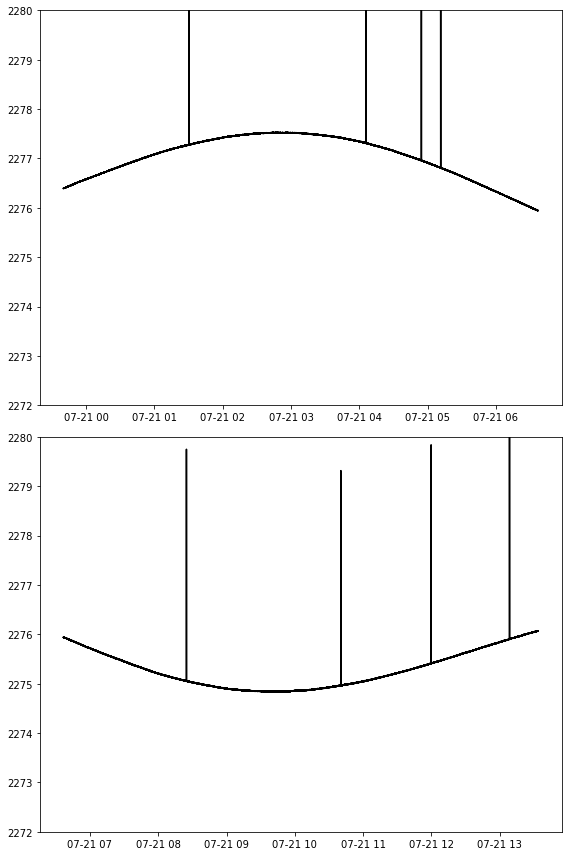

In [4]:
tmp=[]
tmptime=[]
nplots = 2                     # this can be 40 if you like

startindex = 3000000
datablock = 500000             # for 20 samples / sec use 72000 to get one hour
                               # for 1 sample / sec use a small startindex and datablock of say 200k 

for i in range(nplots):
    tmp.append(ds.isel(obs=slice(startindex + i*datablock, startindex + i*datablock + datablock)).bottom_pressure)
    tmptime.append(ds.isel(obs=slice(startindex + i*datablock, startindex + i*datablock + datablock)).time)

fig, axs = plt.subplots(nplots, 1, figsize=(8, 6*nplots), tight_layout=True)

for i in range(nplots):
    axs[i].plot(tmptime[i], tmp[i], color='k')
    axs[i].set(ylim = (2272, 2280))


In [5]:
# move to background: This compares scatter to rolling mean
# tmpsub, tmpsubtime, tmproll = [], [], []

# nobs=50
# nplots = 2
# datablock = 1000             
# slice_start = 100
# for i in range(nplots):
#     tmpsub.append(tmp[0].isel(obs=slice(slice_start + i*datablock, slice_start + i*datablock + datablock)))
#     tmpsubtime.append(tmptime[0].isel(obs=slice(slice_start + i*datablock, slice_start + i*datablock + datablock)))
#     tmproll.append(tmp[0].isel(obs=slice(slice_start + i*datablock, slice_start + i*datablock + datablock)).rolling(obs=nobs, center=True).mean())

# fig, axs = plt.subplots(nplots, 1, figsize=(36, 12*nplots), tight_layout=True)

# for i in range(nplots):
#     axs[i].plot(tmpsubtime[i], tmproll[i], color='r')
#     axs[i].scatter(tmpsubtime[i], tmpsub[i], color='k', marker='.')
#     # axs[i].set(ylim = (2275.95, 2276.05))

# Notice 1-second intervals; this switches over to the expected 20 samples per second
# ds.time[0:10] 

# Smoking gun plot: Sometimes the data are one sample per second, sometimes 20 samples per second
# ds.time.plot()

# fig, axs = plt.subplots(2, 1, figsize=(36, 24), tight_layout=True)

# tmp1 = tmp[0].isel(obs=slice(3200,3400))
# tmp2 = tmp[0].isel(obs=slice(4200,4400))

# axs[0].scatter(tmp1.obs, tmp1, marker='.', color='r')
# axs[1].scatter(tmp2.obs, tmp2, marker='.', color='k')

# Suspect now that we see this is one sample per second

## Average

Let's get a single depth for the entire dataset. Then go get a couple more near this time; and then go to later in the record by a couple years and see if there is a consistent change.

In [13]:
# I will merge some test cells here...

ds=xr.open_dataset(pressurefiles[0]).swap_dims({'obs':'time'})
da_day = ds.bottom_pressure.resample(time='1D').mean()
da_day

ds.time[0], ds.time[-1]

da_day.mean()

xr.open_dataset(data_dir + 'botpt/botpt.nc').swap_dims({'obs':'time'}).bottom_pressure.resample(time='1D').mean().mean()

xr.open_dataset(datafiles[0]).swap_dims({'obs':'time'}).bottom_pressure.mean()

xr.open_dataset(datafiles[0]).bottom_pressure.mean()

In [8]:
%%time 

# DataArray lists (runs in about four minutes)
mean_pressure_per_file = [xr.open_dataset(src).bottom_pressure.mean() for src in pressurefiles]
startdate_per_file = [xr.open_dataset(src).time[0] for src in pressurefiles]

pressure = [float(mean_pressure_per_file[i]) for i in range(len(mean_pressure_per_file))]
ptimes = [dt64(startdate_per_file[i].values) for i in range(len(startdate_per_file))]

CPU times: user 1min 54s, sys: 1min 5s, total: 2min 59s
Wall time: 3min 38s


In [15]:
pd_dframe = pd.DataFrame(list(zip(ptimes, pressure)), columns=['datetime', 'pressure'])
pd_dframe.to_csv('pressure_data.csv')

[(2276.4, 2275.4)]

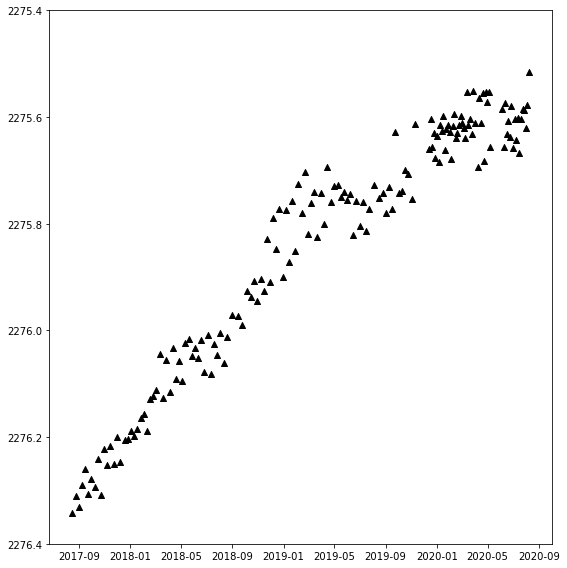

In [16]:
# payoff
fig, axs = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
axs.scatter(ptimes, pressure, marker='^', color='k')
axs.set(ylim = (2276.4, 2275.4))

# tilt (lily)

In [18]:
tiltfiles = glob.glob('/data/botpt/lily/deployment*.nc')
print('there are ' + str(len(tiltfiles)) + ' data files available for tilt')

there are 8 data files available for tilt


In [41]:
# this works fine, takes a couple few minutes
# ds = [xr.open_dataset(tiltfile).swap_dims({'obs':'time'}) for tiltfile in tiltfiles]

In [27]:
# 
# this also took a couple minutes
# ds_concat=xr.concat(ds, 'time')
# ds_concat

<xarray.Dataset>
Dimensions:                                  (time: 88404922)
Coordinates:
    obs                                      (time) int32 0 1 ... 9174224
  * time                                     (time) datetime64[ns] 2017-08-15...
Data variables:
    sensor_id                                (time) object b'LILY' ... b'LILY'
    seafloor_tilt_direction_qc_executed      (time) uint8 1 1 1 1 1 ... 1 1 1 1
    compass_direction                        (time) float32 201.1 ... 200.46
    driver_timestamp                         (time) datetime64[ns] 2017-08-15...
    id                                       (time) |S36 b'387429a7-6af8-43e3...
    corrected_compass_direction_qc_results   (time) uint8 1 1 1 1 1 ... 1 1 1 1
    compass_direction_qc_executed            (time) uint8 1 1 1 1 1 ... 1 1 1 1
    seafloor_tilt_magnitude_qc_results       (time) uint8 0 0 0 0 0 ... 1 1 1 1
    seafloor_tilt_direction                  (time) float64 120.0 ... 238.0
    ingestion_timestamp                      (time) datetime64[ns] 2017-08-15...
    internal_timestamp                       (time) datetime64[ns] 2017-08-15...
    lily_y_tilt                              (time) float32 -330.0 ... -65.449
    seafloor_tilt_direction_qc_results       (time) uint8 1 1 1 1 1 ... 1 1 1 1
    serial_number                            (time) object b'N9651' ... b'N9651'
    lily_x_tilt                              (time) float32 330.0 ... -194.272
    corrected_compass_direction_qc_executed  (time) uint8 1 1 1 1 1 ... 1 1 1 1
    seafloor_tilt_magnitude_qc_executed      (time) uint8 1 1 1 1 1 ... 1 1 1 1
    seafloor_tilt_magnitude                  (time) float32 466.6905 ... 205....
    date_time_string                         (time) object b'2017/08/15 00:10...
    port_timestamp                           (time) datetime64[ns] 2017-08-15...
    deployment                               (time) int32 3 3 3 3 3 ... 3 3 3 3
    supply_voltage                           (time) float32 11.87 ... 11.87
    preferred_timestamp                      (time) object b'internal_timesta...
    compass_direction_qc_results             (time) uint8 0 0 0 0 0 ... 0 0 0 0
    corrected_compass_direction              (time) float64 345.0 ... 347.0
    lily_temp                                (time) float32 0.78 0.81 ... 4.89
Attributes:
    node:                            MJ03B
    comment:                         
    publisher_email:                 
    sourceUrl:                       http://oceanobservatories.org/
    collection_method:               streamed
    stream:                          botpt_lily_sample
    featureType:                     point
    creator_email:                   
    publisher_name:                  Ocean Observatories Initiative
    date_modified:                   2020-08-11T14:18:37.325335
    keywords:                        
    cdm_data_type:                   Point
    references:                      More information can be found at http://...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    date_created:                    2020-08-11T14:18:37.325330
    id:                              RS03ASHS-MJ03B-09-BOTPTA304-streamed-bot...
    requestUUID:                     c196a158-ae11-47f0-bcd7-6f59c74d0db9
    contributor_role:                
    summary:                         Dataset Generated by Stream Engine from ...
    keywords_vocabulary:             
    institution:                     Ocean Observatories Initiative
    naming_authority:                org.oceanobservatories
    feature_Type:                    point
    infoUrl:                         http://oceanobservatories.org/
    license:                         
    contributor_name:                
    uuid:                            c196a158-ae11-47f0-bcd7-6f59c74d0db9
    creator_name:                    Ocean Observatories Initiative
    title:                           Data produced by Stream Engine version 1...
    sensor

In [28]:
# 4GB output file
# ds_concat.to_netcdf('/data/botpt/lily/full_time_series.nc')

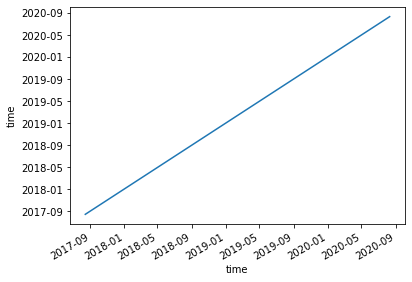

In [29]:
ds_concat.time.plot()

In [31]:
ds_days = ds_concat.resample(time="1D").mean()
ds_days

/home/ubuntu/anaconda3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:                                  (time: 1092)
Coordinates:
  * time                                     (time) datetime64[ns] 2017-08-15...
Data variables:
    seafloor_tilt_direction_qc_executed      (time) float64 1.0 1.0 ... 1.0 1.0
    compass_direction                        (time) float32 200.98834 ... 200...
    corrected_compass_direction_qc_results   (time) float64 1.0 1.0 ... 1.0 1.0
    compass_direction_qc_executed            (time) float64 1.0 1.0 ... 1.0 1.0
    seafloor_tilt_magnitude_qc_results       (time) float64 0.0 0.0 ... 1.0 1.0
    seafloor_tilt_direction                  (time) float64 120.0 ... 237.7
    lily_y_tilt                              (time) float32 -330.0 ... -66.41...
    seafloor_tilt_direction_qc_results       (time) float64 1.0 1.0 ... 1.0 1.0
    lily_x_tilt                              (time) float32 330.0 ... -194.31395
    corrected_compass_direction_qc_executed  (time) float64 1.0 1.0 ... 1.0 1.0
    seafloor_tilt_magnitude_qc_executed      (time) float64 1.0 1.0 ... 1.0 1.0
    seafloor_tilt_magnitude                  (time) float32 466.6905 ... 205....
    deployment                               (time) float64 3.0 3.0 ... 3.0 3.0
    supply_voltage                           (time) float32 11.869998 ... 11....
    compass_direction_qc_results             (time) float64 0.0 0.0 ... 0.0 0.0
    corrected_compass_direction              (time) float64 345.0 ... 346.7
    lily_temp                                (time) float32 4.0182657 ... 4.8...

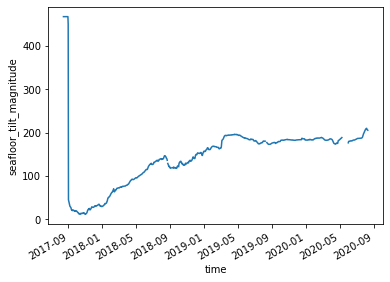

In [32]:
ds_days.seafloor_tilt_magnitude.plot()

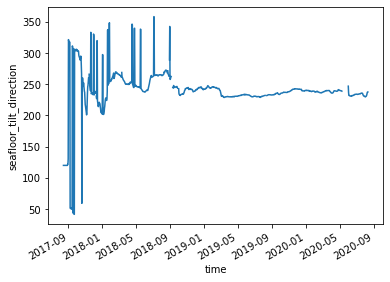

In [33]:
ds_days.seafloor_tilt_direction.plot()

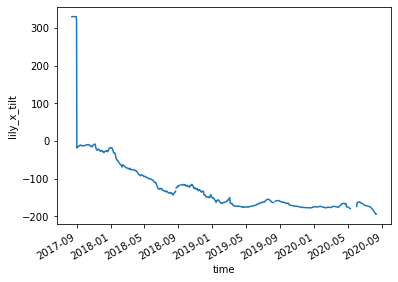

In [37]:
ds_days.lily_x_tilt.plot()

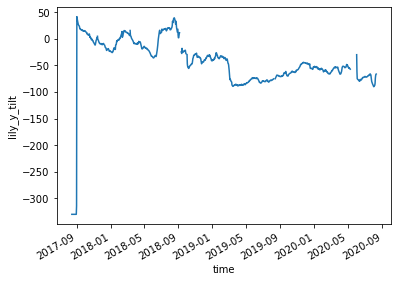

In [38]:
ds_days.lily_y_tilt.plot()

In [40]:
ds_days.to_netcdf('/data/botpt/lily/full_daily_series.nc')

In [47]:
# ds_concat.obs.plot() shows a few jukes here and there

# heat

In [48]:
# deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_heat_sample_20170815T001037-20181107T235958.nc
# deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_heat_sample_20181108T000001-20200119T235958.nc
# deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_heat_sample_20200120T000001-20200810T224044.nc

heatfiles = glob.glob('/data/botpt/heat/deployment*.nc')
print('there are ' + str(len(heatfiles)) + ' data files available for heat')

there are 3 data files available for heat


In [49]:
%%time

ds = [xr.open_dataset(heatfile).swap_dims({'obs':'time'}) for heatfile in heatfiles]
ds_concat=xr.concat(ds, 'time')
ds_concat

CPU times: user 24.2 s, sys: 4.14 s, total: 28.4 s
Wall time: 28.4 s


<xarray.Dataset>
Dimensions:              (time: 32433077)
Coordinates:
    obs                  (time) int32 0 1 2 3 ... 5692931 5692932 5692933
  * time                 (time) datetime64[ns] 2017-08-15T00:10:37 ... 2020-0...
Data variables:
    preferred_timestamp  (time) object b'internal_timestamp' ... b'internal_t...
    heat_temp            (time) float32 2.0 2.0 2.0 2.0 2.0 ... 6.0 7.0 7.0 7.0
    heat_y_tilt          (time) float32 -1.0 -1.0 -1.0 -1.0 ... 0.0 0.0 0.0 0.0
    date_time_string     (time) object b'2017/08/15 00:10:37' ... b'2020/08/1...
    port_timestamp       (time) datetime64[ns] 2017-08-15T00:10:37.912924672 ...
    deployment           (time) int32 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3
    id                   (time) |S36 b'cf1f8628-476c-415f-b99b-1ad17ceac968' ...
    ingestion_timestamp  (time) datetime64[ns] 2017-08-15T00:10:42.437000192 ...
    sensor_id            (time) object b'HEAT' b'HEAT' ... b'HEAT' b'HEAT'
    internal_timestamp   (time) datetime64[ns] 2017-08-15T00:10:37 ... 2020-0...
    driver_timestamp     (time) datetime64[ns] 2017-08-15T00:10:37.943220224 ...
    heat_x_tilt          (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    node:                            MJ03B
    comment:                         
    publisher_email:                 
    sourceUrl:                       http://oceanobservatories.org/
    collection_method:               streamed
    stream:                          botpt_heat_sample
    featureType:                     point
    creator_email:                   
    publisher_name:                  Ocean Observatories Initiative
    date_modified:                   2020-08-11T12:42:19.951129
    keywords:                        
    cdm_data_type:                   Point
    references:                      More information can be found at http://...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    date_created:                    2020-08-11T12:42:19.951123
    id:                              RS03ASHS-MJ03B-09-BOTPTA304-streamed-bot...
    requestUUID:                     e6cfdf49-aad2-416b-ab87-a8848ad73056
    contributor_role:                
    summary:                         Dataset Generated by Stream Engine from ...
    keywords_vocabulary:             
    institution:                     Ocean Observatories Initiative
    naming_authority:                org.oceanobservatories
    feature_Type:                    point
    infoUrl:                         http://oceanobservatories.org/
    license:                         
    contributor_name:                
    uuid:                            e6cfdf49-aad2-416b-ab87-a8848ad73056
    creator_name:                    Ocean Observatories Initiative
    title:                           Data produced by Stream Engine version 1...
    sensor:                          09-BOTPTA304
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    acknowledgement:                 
    Conventions:                     CF-1.6
    project:                         Ocean Observatories Initiative
    source:                          RS03ASHS-MJ03B-09-BOTPTA304-streamed-bot...
    publisher_url:                   http://oceanobservatories.org/
    creator_url:                     http://oceanobservatories.org/
    nodc_template_version:           NODC_NetCDF_TimeSeries_Orthogonal_Templa...
    subsite:                         RS03ASHS
    processing_level:                L2
    history:                         2020-08-11T12:42:19.951061 generated fro...
    time_coverage_start:             2017-08-15T00:10:37
    time_coverage_end:               2018-11-07T23:59:58
    time_coverage_resolution:        P2.89S
    geospatial_lat_min:              45.93363
    geospatial_lat_max:              45.93363
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       0.1
    geospatial_lon_min:              -130.01368
  

[(0.0, 0.0001)]

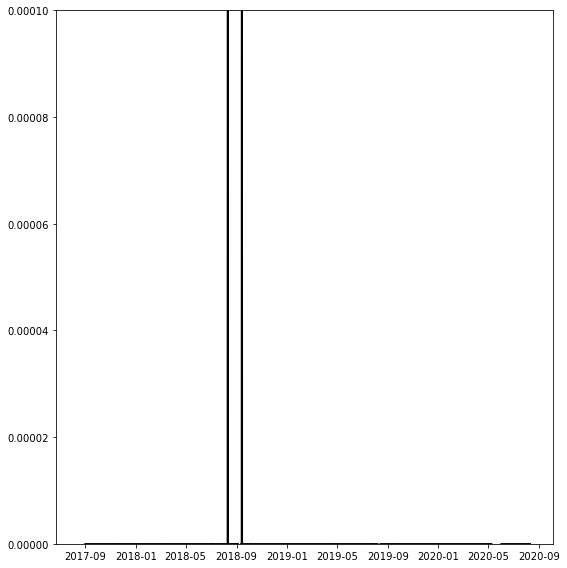

In [18]:
# ds_days = ds_concat.resample(time="1D").mean()
# ds_days.to_netcdf('/data/botpt/heat/heat_full_record_1day.nc')
ds_days = xr.open_dataset('/data/botpt/heat/heat_full_record_1day.nc')

fig, axs = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
axs.plot(ds_days.time, ds_days.heat_y_tilt, color='k')
axs.set(ylim = (0., 0.0001))

# iris

In [3]:
%%time

irisfiles = glob.glob('/data/botpt/iris/deployment*.nc')
print('there are ' + str(len(irisfiles)) + ' data files available for iris')

ds = [xr.open_dataset(irisfile).swap_dims({'obs':'time'}) for irisfile in irisfiles]
ds_concat=xr.concat(ds, 'time')
ds_days = ds_concat.resample(time="1D").mean()
ds_days.to_netcdf('/data/botpt/iris/iris_full_record_1day.nc')
ds_days.keys

there are 6 data files available for iris
CPU times: user 1min, sys: 12.6 s, total: 1min 13s
Wall time: 1min 19s


<bound method Mapping.keys of <xarray.Dataset>
Dimensions:      (time: 1092)
Coordinates:
  * time         (time) datetime64[ns] 2017-08-15 2017-08-16 ... 2020-08-10
Data variables:
    iris_x_tilt  (time) float32 0.09331934 0.077284455 ... 0.06823581 0.06829865
    deployment   (time) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
    iris_y_tilt  (time) float32 -2.0106528 -2.006727 ... -2.0097306 -2.0096967
    iris_temp    (time) float32 4.3041105 4.497275 ... 4.538286 4.530038>

[(0.068, 0.082)]

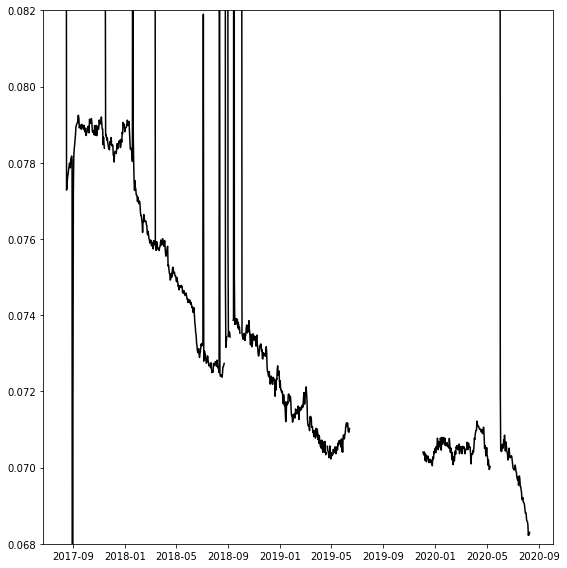

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
axs.plot(ds_days.time, ds_days.iris_x_tilt, color='k')
axs.set(ylim = (.068, .082))

[(-2.012, -2.002)]

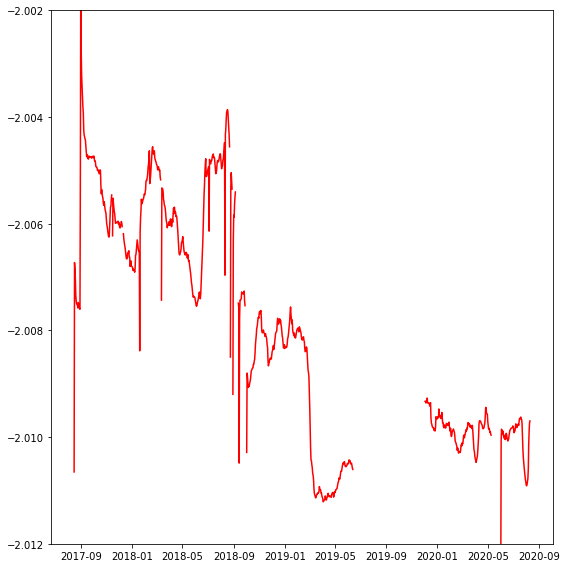

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
axs.plot(ds_days.time, ds_days.iris_y_tilt, color='r')
axs.set(ylim = (-2.012, -2.002))